## Day 48 Lecture 2 Assignment

In this assignment, we will apply density-based clustering to a dataset containing the locations of all Starbucks in the U.S.

This assignment will also use the haversine and plotly packages, which you should already have installed from the previous assignment.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude

Load in the dataset.

In [2]:
# answer goes here
url = 'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv'

starbucks_df = pd.read_csv(url)

Begin by narrowing down the dataset to a specific geographic area of interest. Try just the United States; since you won't be calculating a distance matrix you can use more than just one state.

In [3]:
# answer goes here
us_starbucks = starbucks_df.loc[(starbucks_df['Country']=='US')]

us_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
11964,Starbucks,3513-125945,Safeway-Anchorage #1809,Licensed,5600 Debarr Rd Ste 9,Anchorage,AK,US,995042300,907-339-0900,GMT-09:00 America/Anchorage,-149.78,61.21
11965,Starbucks,74352-84449,Safeway-Anchorage #2628,Licensed,1725 Abbott Rd,Anchorage,AK,US,995073444,907-339-2800,GMT-09:00 America/Anchorage,-149.84,61.14
11966,Starbucks,12449-152385,Safeway - Anchorage #1813,Licensed,1501 Huffman Rd,Anchorage,AK,US,995153596,907-339-1300,GMT-09:00 America/Anchorage,-149.85,61.11
11967,Starbucks,24936-233524,100th & C St - Anchorage,Company Owned,"320 W. 100th Ave, 100, Southgate Shopping Ctr ...",Anchorage,AK,US,99515,(907) 227-9631,GMT-09:00 America/Anchorage,-149.89,61.13
11968,Starbucks,8973-85630,Old Seward & Diamond,Company Owned,1005 E Dimond Blvd,Anchorage,AK,US,995152050,907-344-4160,GMT-09:00 America/Anchorage,-149.86,61.14


Build a DBSCAN clustering model using eps=2 (miles) and min_samples=5. Some tips that may be helpful:

1. Unlike our approach for hierarchical clustering, we do not need to calculate the NxN distance matrix for DBSCAN upfront. It directly supports the haversine distance metric, provided the nearest-neighbors algorithm is a ball tree. Set the "algorithm" and "metric" parameters to the appropriate values. 
2. Scikit-learn's implementation of haversine distance expects radians instead of degrees. Therefore, it would be advisable to create two new columns, Lat_Rad and Lon_Rad, that convert the Latitude and Longitude columns into radians. (Hint: there is a numpy function that does this.)  
3. The eps parameter, which corresponds to the radius of the neighborhood, will also need to be in radians. The conversion factor for miles to radians is approximately 1/3958.748; in other words, if you want the neighborhood to have a radius of 3 miles, set eps = 3/3958.748.  

Side note: ball-tree is an indexing structure that is very useful for nearest-neighbor calculations. The general time-complexity of finding a nearest neighbor using a Ball Tree is O(nlog(n)). This is a vast improvement over the naive O($n^{2}$) and allows us to cluster on much larger subsets of the data, like the entire country. Scikit-learn directly supports creating ball-trees through sklearn.neighbors.BallTree; if inclined, you could extend the analysis in the first after-lecture assignment (in which we calculated a similarity matrix for Hawaii) to the entire country using a BallTree and identify "island Starbucks locations" on a much larger scale.

Additionally, save the predicted cluster assignments as a new column in your dataframe.

In [4]:
us_starbucks['Lat_Rad'] = np.radians(us_starbucks['Latitude'])
us_starbucks['Lon_Rad'] = np.radians(us_starbucks['Longitude'])
us_starbucks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Lat_Rad,Lon_Rad
11964,Starbucks,3513-125945,Safeway-Anchorage #1809,Licensed,5600 Debarr Rd Ste 9,Anchorage,AK,US,995042300,907-339-0900,GMT-09:00 America/Anchorage,-149.78,61.21,1.068316,-2.614154
11965,Starbucks,74352-84449,Safeway-Anchorage #2628,Licensed,1725 Abbott Rd,Anchorage,AK,US,995073444,907-339-2800,GMT-09:00 America/Anchorage,-149.84,61.14,1.067094,-2.615201
11966,Starbucks,12449-152385,Safeway - Anchorage #1813,Licensed,1501 Huffman Rd,Anchorage,AK,US,995153596,907-339-1300,GMT-09:00 America/Anchorage,-149.85,61.11,1.066571,-2.615376
11967,Starbucks,24936-233524,100th & C St - Anchorage,Company Owned,"320 W. 100th Ave, 100, Southgate Shopping Ctr ...",Anchorage,AK,US,99515,(907) 227-9631,GMT-09:00 America/Anchorage,-149.89,61.13,1.066920,-2.616074
11968,Starbucks,8973-85630,Old Seward & Diamond,Company Owned,1005 E Dimond Blvd,Anchorage,AK,US,995152050,907-344-4160,GMT-09:00 America/Anchorage,-149.86,61.14,1.067094,-2.615550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25567,Starbucks,74385-87621,Safeway-Laramie #2466,Licensed,554 N 3rd St,Laramie,WY,US,820723012,307-721-5107,GMT-07:00 America/Denver,-105.59,41.32,0.721170,-1.842893
25568,Starbucks,73320-24375,Ridley's - Laramie #1131,Licensed,3112 E. Grand,Laramie,WY,US,820705141,307-742-8146,GMT-07:00 America/Denver,-105.56,41.31,0.720996,-1.842370
25569,Starbucks,22425-219024,Laramie - Grand & 30th,Company Owned,3021 Grand Ave,Laramie,WY,US,82070,307-742-3262,GMT-07:00 America/Denver,-105.56,41.31,0.720996,-1.842370
25570,Starbucks,10849-103163,I-80 & Dewar Dr-Rock Springs,Company Owned,118 Westland Way,Rock Springs,WY,US,829015751,307-362-7145,GMT-07:00 America/Denver,-109.25,41.58,0.725708,-1.906772


In [5]:
X = us_starbucks[['Lat_Rad', 'Lon_Rad']]

In [6]:
# answer goes here
eps = 2/3958.748
dbscan_cluster = DBSCAN(eps=eps, min_samples=5, metric="haversine", algorithm='ball_tree')

us_starbucks['db_clusters'] = dbscan_cluster.fit_predict(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
us_starbucks['db_clusters'].value_counts()

-1      6881
 31      345
 26      336
 265     307
 397     225
        ... 
 159       4
 297       4
 280       4
 106       4
 416       3
Name: db_clusters, Length: 426, dtype: int64

In [8]:
dbscan_cluster.labels_

array([ 0,  1,  1, ..., -1, -1, -1])

In [9]:
silhouette_score(X, dbscan_cluster.labels_, metric='euclidean')

-0.27864415919662655

Finally, plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo

How many clusters did DBSCAN produce? How many locations were treated as outliers (cluster = -1)?

In [20]:
# answer goes here
fig = px.scatter_geo(data_frame=us_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='db_clusters', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=us_starbucks['Longitude'].mean())
fig.update_geos(center_lat=us_starbucks['Latitude'].mean())
fig.show()

From the previous plot, we should see a very large number of clusters (400+). This would suggest that our definition of neighborhood may have been too strict. Experiment with other values of eps and min_samples and see how your changes affect the output. Output a map with what you think is the "best" clustering result below.

In [11]:
# answer goes here
db_clusters = []
silhouette_scores = []

for i in range(5,50,5):
  for min_sample in range(2,11,2):
    eps = i/3958.748
    dbscan_cluster = DBSCAN(eps=eps, min_samples=min_sample, metric="haversine", algorithm='ball_tree')
    db_clusters.append(dbscan_cluster.fit_predict(X))
    silhouette_scores.append(silhouette_score(X, dbscan_cluster.labels_, metric='euclidean'))

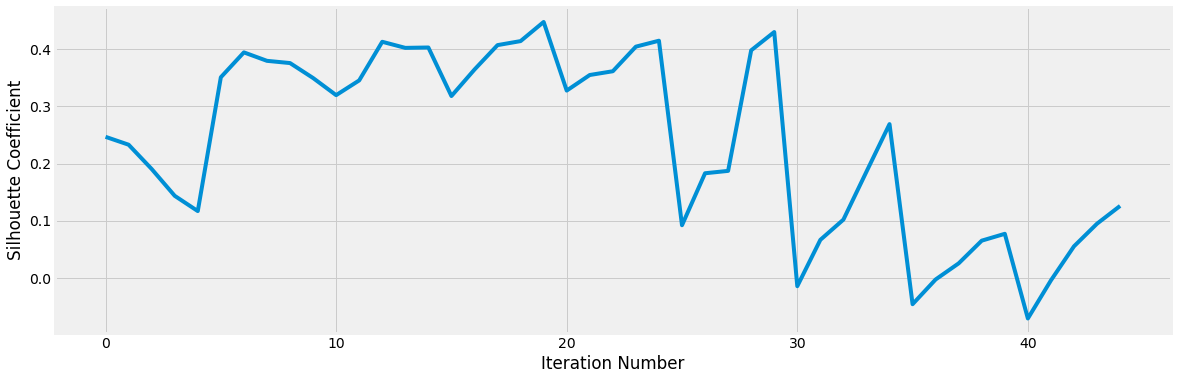

In [12]:
plt.figure(figsize=(20,6))
plt.style.use("fivethirtyeight")
plt.plot(range(len(silhouette_scores)), silhouette_scores)
plt.xlabel("Iteration Number")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [17]:
max(silhouette_scores)

0.44769564459027783

In [14]:
best_i = silhouette_scores.index(max(silhouette_scores))
best_i

19

In [15]:
us_starbucks['best_db_clusters'] = db_clusters[best_i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
fig = px.scatter_geo(data_frame=us_starbucks, lat='Latitude', lon='Longitude', hover_name='Store Name', color='best_db_clusters', color_continuous_scale='spectral')
fig.update_geos(scope='usa')
fig.update_geos(center_lon=us_starbucks['Longitude'].mean())
fig.update_geos(center_lat=us_starbucks['Latitude'].mean())
fig.show()

In [18]:
us_starbucks['best_db_clusters'].value_counts()

 20    1718
 10    1558
-1     1290
 11    1007
 42     618
       ... 
 67      10
 70      10
 26      10
 8       10
 60      10
Name: best_db_clusters, Length: 110, dtype: int64